<a href="https://colab.research.google.com/github/hiteshisawariya485/Signature_Verification/blob/main/googlenet_V3(TL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/DATASET'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load and preprocess images (converted to RGB for Inception)
def load_data(image_size=(224, 224)):
    X, y = [], []
    for label, folder in enumerate(['full_forg', 'full_org']):
        folder_path = os.path.join(DATA_PATH, folder)
        for file in os.listdir(folder_path):
            path = os.path.join(folder_path, file)
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            img = img / 255.0
            X.append(img)
            y.append(label)
    return np.array(X), to_categorical(np.array(y), num_classes=2)

X, y = load_data()

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42) # Split data into 70% train and 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42) # Further split temp data into 15% val and 15% test


In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

train_gen = datagen.flow(X_train, y_train, batch_size=16)
val_gen = datagen.flow(X_val, y_val, batch_size=16)


In [ ]:
# Load pretrained InceptionV3 model (exclude top)
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False #freeze base

In [ ]:
# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)


In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,065,314 (84.17 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)


In [ ]:
# Train model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=[early_stop, lr_reduce]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 72s 464ms/step - accuracy: 0.6049 - loss: 0.7128 - val_accuracy: 0.8433 - val_loss: 0.4280 - learning_rate: 1.0000e-04
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - accuracy: 0.8156 - loss: 0.4330 - val_accuracy: 0.8234 - val_loss: 0.3829 - learning_rate: 1.0000e-04
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 41s 243ms/step - accuracy: 0.8589 - loss: 0.3266 - val_accuracy: 0.8483 - val_loss: 0.3343 - learning_rate: 1.0000e-04
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 33s 282ms/step - accuracy: 0.8752 - loss: 0.3036 - val_accuracy: 0.9229 - val_loss: 0.2352 - learning_rate: 1.0000e-04
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 28s 240ms/step - accuracy: 0.9042 - loss: 0.2419 - val_accuracy: 0.9328 - val_loss: 0.2101 - learning_rate: 1.0000e-04
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 28s 241ms/step - accuracy: 0.9066 - loss: 0.2200 - val_accuracy: 0.9577 - val_loss: 0.1813 - learning_rate: 1.0000e-04
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluate model performance
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


Test Accuracy: 0.9826
Validation Accuracy: 98.76%
Validation Loss: 0.0334


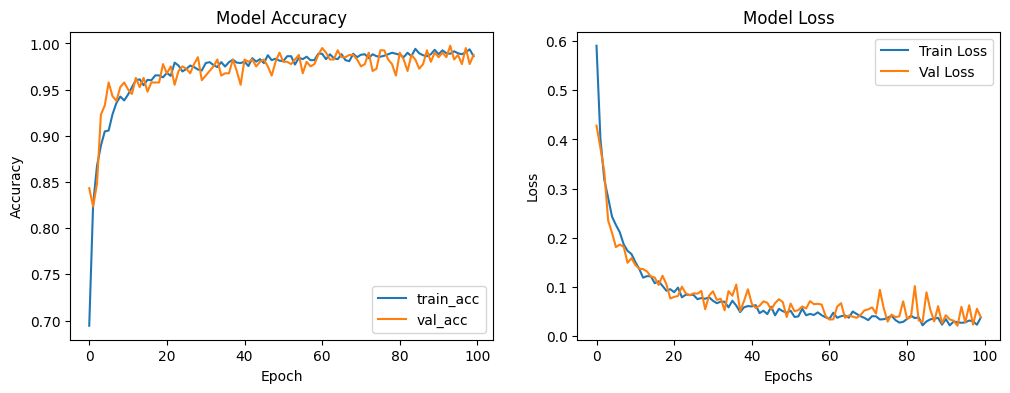

In [ ]:
# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


In [ ]:
# Predict on Validation Data
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
# Get the true labels from y_val
# Reset the validation generator before predicting
val_gen.reset()
y_true = np.argmax(y_val, axis=-1)  # Use all y_val without indexing

26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 408ms/step


In [ ]:
# Ensure both y_true and y_pred have the same length
num_samples = min(len(y_true), len(y_pred))
y_true = y_true[:num_samples]
y_pred = y_pred[:num_samples]


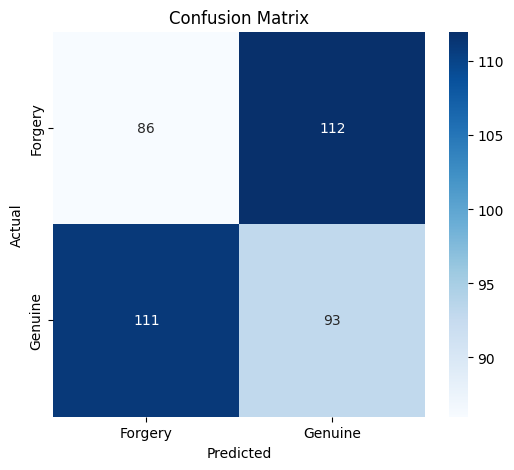

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forgery', 'Genuine'], yticklabels=['Forgery', 'Genuine'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Precision, Recall, F1 score
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.4537
Recall:    0.4559
F1 Score:  0.4548
